# Homicides in Mexico

In this notebook, we use time series analysis to explore the total and per 100,000 people number of homicides (1997 to 2021) and feminicides (2015 to 2021) in Mexico. We will
* Explore this numbers at national level and in the capital city 'cdmx'
* Use a Verhulst logistic model for the population growth
* Use this model to adjust time series according to the instantaneous population
* Implement an additive decomposition to extract the trend and seasonality
* Implement a simple SARIMA model and test its predictability


### Few remarks before starting:

- Time series are the result of the convolution of effects coming from the underlying phenomena. And of course, creating chaos is easier (faster) than creating stability.

- Time series have different levels of volatility/elasticity depending on the process: 

    - A finantial time series can show the effects of a declaration from Trump or Elon Musk in a matter of minutes and have lasting effects for weeks. 

    - The Covid-19 pandemic curves show effects 15 days after a holiday or change in a policy and their effects may last for months. 

    - In the case of homicides/feminicides, policies seem to show effects 6 months after their deployment and last for a few years. 
    
- Adjusting for population (per 100,000 people in this case) is absolutely necessary when comparing different locations or times. Losing 10 persons to crime in a polulation of a hundred people is not the same than losing the same amount in a population of a million people. From a humanistic point of view we cannot trivialize those 10 deaths in either case.

- Keep in mind that data adjusted per capita is useful for policy making, but a problem can easily be overlooked at when averaging over big populations. It is better to disaggregate data locally whenever possible. That is, the 

- Never forget that, by definition, time-dependant processes are in constant evolution and what is true today could no longer be true tomorrow. Only the past is fixed.

## Fire up our libraries

In [1]:
import warnings
import itertools
import scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns

from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

# Load in data

Crime dataset was downloaded from the [SNSP website](https://www.gob.mx/sesnsp/acciones-y-programas/datos-abiertos-de-incidencia-delictiva), where data is divided in three sets:
[From 1997 to 2017](https://drive.google.com/file/d/1wWQDjqslBfZoYwqvl7FQICZ_bbrZdPbO/view),
[from 2011 to 2017](https://drive.google.com/file/d/16XWFoqdNIlunmZotbkMTnj05GkBZyj7Q/view)
and [from 2015 to 2021](https://drive.google.com/file/d/1Fc8iKWSSPrDW9j9Z94SUf5bIsL2Dds74/view?usp=sharing). 

The reason is a change to a 'new methodology' as stated in the SNSP website.
For our purpose this means that before 2015, feminicides were accounted as (intentional) homicides.
Before 2011 (The first dataset) crimes are divided by state but not by municipality.

Population data was captured by hand from the 2020 INEGI Population and Housing Census for the [whole country](http://cuentame.inegi.org.mx/poblacion/habitantes.aspx?tema=P%20])
and the 
[capital city](http://cuentame.inegi.org.mx/monografias/informacion/df/poblacion/dinamica.aspx?tema=me&e=09).

```{caution}
Please notice that if you want to reproduce the results in this notebook you will need to download the datasets and store them in the same folder of your cloned repository.
```

In [2]:
# We first load the crime dataset from 1997 to 2017
crimes_old = pd.read_excel('IncidenciaDelictiva_FueroComun_Estatal_1997-2017 febrero2021.xlsx', engine='openpyxl')
crimes_old.head()

,AÑO,INEGI,ENTIDAD,MODALIDAD,TIPO,SUBTIPO,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE
0,1997,1,AGUASCALIENTES,DELITOS PATRIMONIALES,ABUSO DE CONFIANZA,ABUSO DE CONFIANZA,17,17,17,17,17,17,32,0,38,28,22,31
1,1997,1,AGUASCALIENTES,DELITOS PATRIMONIALES,DAÑO EN PROPIEDAD AJENA,DAÑO EN PROPIEDAD AJENA,45,45,45,45,45,45,108,40,117,38,73,133
2,1997,1,AGUASCALIENTES,DELITOS PATRIMONIALES,EXTORSION,EXTORSION,0,0,0,0,0,0,0,0,0,0,0,0
3,1997,1,AGUASCALIENTES,DELITOS PATRIMONIALES,FRAUDE,FRAUDE,9,9,9,9,9,9,52,0,55,51,42,44
4,1997,1,AGUASCALIENTES,DELITOS PATRIMONIALES,DESPOJO,CON VIOLENCIA,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# We then load the crime dataset from 2011 to 2017
crimes = pd.read_csv('IDM_feb2021.csv', engine='python')
crimes.head()

,A�O,INEGI,ENTIDAD,MUNICIPIO,MODALIDAD,TIPO,SUBTIPO,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE
0,2011,1001,AGUASCALIENTES,AGUASCALIENTES,DELITOS PATRIMONIALES,ABUSO DE CONFIANZA,ABUSO DE CONFIANZA,45.0,43.0,34.0,22.0,36.0,43.0,37.0,38.0,37.0,35.0,32.0,28.0
1,2011,1001,AGUASCALIENTES,AGUASCALIENTES,DELITOS PATRIMONIALES,DA�O EN PROPIEDAD AJENA,DA�O EN PROPIEDAD AJENA,164.0,177.0,160.0,179.0,167.0,149.0,150.0,144.0,171.0,144.0,134.0,173.0
2,2011,1001,AGUASCALIENTES,AGUASCALIENTES,DELITOS PATRIMONIALES,EXTORSION,EXTORSION,10.0,24.0,9.0,7.0,8.0,9.0,9.0,1.0,7.0,6.0,4.0,5.0
3,2011,1001,AGUASCALIENTES,AGUASCALIENTES,DELITOS PATRIMONIALES,FRAUDE,FRAUDE,54.0,29.0,37.0,37.0,53.0,37.0,44.0,36.0,27.0,20.0,38.0,32.0
4,2011,1001,AGUASCALIENTES,AGUASCALIENTES,DELITOS PATRIMONIALES,DESPOJO,CON VIOLENCIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Last but not least we load the crime dataset from 2015 to 2021
crimes_new = pd.read_csv('Municipal-Delitos-2015-2021_abr2021.csv', engine='python', encoding='ISO-8859-1')
crimes_new.head()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1,1,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1,1,3.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Here we capture by hand the population growth at national and capital city level
# Population is given in millions of people

population = pd.DataFrame(columns=['date','national','cdmx'])
population = population.append({'date': 1930, 'national': 16.5,'cdmx' : 1.2}, ignore_index=True)
population = population.append({'date': 1940, 'national': 19.4,'cdmx' : 1.8}, ignore_index=True)
population = population.append({'date': 1950, 'national': 25.8,'cdmx' : 3.1}, ignore_index=True)
population = population.append({'date': 1960, 'national': 34.9,'cdmx' : 4.9}, ignore_index=True)
population = population.append({'date': 1970, 'national': 48.2,'cdmx' : 6.9}, ignore_index=True)
population = population.append({'date': 1980, 'national': 66.8,'cdmx' : 8.8}, ignore_index=True)
population = population.append({'date': 1990, 'national': 81.2,'cdmx' : 8.2}, ignore_index=True)
population = population.append({'date': 2000, 'national': 97.5,'cdmx' : 8.6}, ignore_index=True)
population = population.append({'date': 2010, 'national': 112.3,'cdmx' : 8.9}, ignore_index=True)
population = population.append({'date': 2020, 'national': 126.0,'cdmx' : 9.2}, ignore_index=True)
#population

In [6]:
# Here we capture by hand the population in 2020 by state
# Creating a time series for population growth per state is beyond the scope of this study

population2020 = pd.DataFrame(columns=['state','people'])
population2020 = population2020.append({'state': 'AGUASCALIENTES', 'people': 1425607}, ignore_index=True)
population2020 = population2020.append({'state': 'BAJA CALIFORNIA', 'people': 3769020}, ignore_index=True)
population2020 = population2020.append({'state': 'BAJA CALIFORNIA SUR', 'people': 798447}, ignore_index=True)
population2020 = population2020.append({'state': 'CAMPECHE', 'people': 928363}, ignore_index=True)
population2020 = population2020.append({'state': 'COAHUILA', 'people': 3146771}, ignore_index=True)
population2020 = population2020.append({'state': 'COLIMA', 'people': 731391}, ignore_index=True)
population2020 = population2020.append({'state': 'CHIAPAS', 'people': 5543828}, ignore_index=True)
population2020 = population2020.append({'state': 'CHIHUAHUA', 'people': 3741869}, ignore_index=True)
population2020 = population2020.append({'state': 'CIUDAD DE MEXICO', 'people': 9209944}, ignore_index=True)
population2020 = population2020.append({'state': 'DURANGO', 'people': 1832650}, ignore_index=True)
population2020 = population2020.append({'state': 'GUANAJUATO', 'people': 6166934}, ignore_index=True)
population2020 = population2020.append({'state': 'GUERRERO', 'people': 3540685}, ignore_index=True)
population2020 = population2020.append({'state': 'HIDALGO', 'people': 3082841}, ignore_index=True)
population2020 = population2020.append({'state': 'JALISCO', 'people': 8348151}, ignore_index=True)
population2020 = population2020.append({'state': 'MEXICO', 'people': 16992418}, ignore_index=True)
population2020 = population2020.append({'state': 'MICHOACAN', 'people': 4748846}, ignore_index=True)
population2020 = population2020.append({'state': 'MORELOS', 'people': 1971520}, ignore_index=True)
population2020 = population2020.append({'state': 'NAYARIT', 'people': 1235456}, ignore_index=True)
population2020 = population2020.append({'state': 'NUEVO LEON', 'people': 5784442}, ignore_index=True)
population2020 = population2020.append({'state': 'OAXACA', 'people': 4132148}, ignore_index=True)
population2020 = population2020.append({'state': 'PUEBLA', 'people': 6583278}, ignore_index=True)
population2020 = population2020.append({'state': 'QUERETARO', 'people': 2368467}, ignore_index=True)
population2020 = population2020.append({'state': 'QUINTANA ROO', 'people': 1857985}, ignore_index=True)
population2020 = population2020.append({'state': 'SAN LUIS POTOSI', 'people': 2822255}, ignore_index=True)
population2020 = population2020.append({'state': 'SINALOA', 'people': 3026943}, ignore_index=True)
population2020 = population2020.append({'state': 'SONORA', 'people': 2944840}, ignore_index=True)
population2020 = population2020.append({'state': 'TABASCO', 'people': 2402598}, ignore_index=True)
population2020 = population2020.append({'state': 'TAMAULIPAS', 'people': 3527735}, ignore_index=True)
population2020 = population2020.append({'state': 'TLAXCALA', 'people': 1342977}, ignore_index=True)
population2020 = population2020.append({'state': 'VERACRUZ', 'people': 8062579}, ignore_index=True)
population2020 = population2020.append({'state': 'YUCATAN', 'people': 2320898}, ignore_index=True)
population2020 = population2020.append({'state': 'ZACATECAS', 'people': 1622138}, ignore_index=True)
#population2020.tail()

# Create a logistic model for population growth

The Verhulst model in a nutshell is a Malthus model (the change in population at instant t is (birth rate-death rate)*population at the same time) plus an interaction term.

See https://en.wikipedia.org/wiki/Pierre_Fran%C3%A7ois_Verhulst for more information on the  model.

We will save the results from our population growth fits for later.

In [7]:
def logistic(x, x0, K, r):
    return K / (1.0 + np.exp( -r*(x-x0) ) )

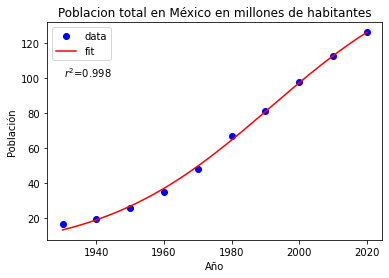

In [8]:
# Here we fit a logistic model to national population

data = population['national'].to_numpy()
x = population['date'].to_numpy()
popt_national, _ = curve_fit(logistic, x, data, p0=[2000., 4., 0.05])

# This part computes r^2 score of our fit
residuals = data - logistic(x, *popt_national)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((data-np.mean(data))**2)
r_squared = 1 - (ss_res / ss_tot)

# This section plots the data and the fit
x_interval_for_fit = np.linspace(x.min(), x.max(), 1000)
plt.plot(x,data,'bo', label='data')
plt.plot(x_interval_for_fit, logistic(x_interval_for_fit, *popt_national),'r-', label='fit')
#This part adds the label for r^2 to the plot
ax = plt.gca()
ax.text(.05, .75, '$r^2$={:.3f}'.format(r_squared) ,transform=ax.transAxes)
plt.title('Poblacion total en México en millones de habitantes')
ax.set_xlabel('Año')
ax.set_ylabel('Población')
plt.legend()
plt.show()

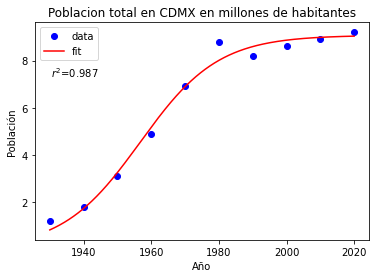

In [9]:
# Here we fit a logistic model to national population

data = population['cdmx'].to_numpy()
x = population['date'].to_numpy()
popt_cdmx, _ = curve_fit(logistic, x, data, p0=[1980., 1., 0.1])

# This part computes r^2 score of our fit
residuals = data - logistic(x, *popt_cdmx)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((data-np.mean(data))**2)
r_squared = 1 - (ss_res / ss_tot)

# This section plots the data and the fit
x_interval_for_fit = np.linspace(x.min(), x.max(), 1000)
plt.plot(x,data,'bo', label='data')
plt.plot(x_interval_for_fit, logistic(x_interval_for_fit, *popt_cdmx),'r-', label='fit')
#This part adds the label for r^2 to the plot
ax = plt.gca()
ax.text(.05, .75, '$r^2$={:.3f}'.format(r_squared) ,transform=ax.transAxes)
plt.title('Poblacion total en CDMX en millones de habitantes')
ax.set_xlabel('Año')
ax.set_ylabel('Población')
plt.legend()
plt.show()

# Clean the crime datasets

In [10]:
cols = ['INEGI','MUNICIPIO','SUBTIPO']
cols_new = ['Clave_Ent', 'Cve. Municipio', 'Municipio', 'Bien jurídico afectado','Tipo de delito']

states = crimes['ENTIDAD'].unique()
states_new = crimes_new['Entidad'].unique()

months = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']

crimes_old = crimes_old.drop(columns = ['INEGI','SUBTIPO'])
crimes_old = crimes_old.dropna()
crimes = crimes.drop(columns = cols)
crimes = crimes.dropna()
crimes_new = crimes_new.drop(columns = cols_new)
crimes_new = crimes_new.dropna()

We make a crosscheck to evaluate if the intersection of the three datasets is consistent.
Though there are some exceptions, we will assume that they are all equally representative of the phenomena.

In [11]:
homicides_old = crimes_old.loc[
    (crimes_old['MODALIDAD'] == 'HOMICIDIOS')
    &(crimes_old['TIPO'] == 'DOLOSOS')]
homicides_old = homicides_old.drop(columns = ['MODALIDAD','TIPO'])
print(homicides_old['MARZO'].loc[
    (homicides_old['ENTIDAD'] == 'ZACATECAS')
    &(homicides_old['AÑO'] == 2016)].sum())

homicides = crimes.loc[
    (crimes['MODALIDAD'] == 'HOMICIDIOS')
    &(crimes['TIPO'] == 'DOLOSOS')]
homicides = homicides.drop(columns = ['MODALIDAD','TIPO'])
print(homicides['MARZO'].loc[
    (homicides['ENTIDAD'] == 'ZACATECAS')
    &(homicides['A�O'] == 2016)].sum())

# For the period 2015 to 2021 we create 2 datasets, 
# one with only feminicides and one with both homicides + feminicides
feminicides = crimes_new.loc[ crimes_new['Subtipo de delito'] == 'Feminicidio' ]
feminicides = feminicides.drop(columns = ['Subtipo de delito','Modalidad'])
homicides_new = crimes_new.loc[
    (crimes_new['Subtipo de delito'] == 'Homicidio doloso') 
    | (crimes_new['Subtipo de delito'] == 'Feminicidio') ]
homicides_new = homicides_new.drop(columns = ['Subtipo de delito','Modalidad'])
print(homicides_new['Marzo'].loc[
    (homicides_new['Entidad'] == 'Zacatecas')
    &(homicides_new['Año'] == 2016)].sum())

28
28.0
28


Now we unify the data coming from all of the datasets

In [12]:
index = 0
df0 = pd.DataFrame(columns=['date','state','homicides','feminicides'])
df1 = pd.DataFrame(columns=['date','state','homicides','feminicides'])
df2 = pd.DataFrame(columns=['date','state','homicides','feminicides'])
for m in months:
    index = index + 1
    for y in range(1997,2011):
        x = str(index) + ', ' + str(y)
        d = datetime.strptime(x, '%m, %Y')
        date = d.strftime('%Y-%m')
        for s in states:
            p = homicides_old[m.upper()].loc[(homicides_old['ENTIDAD'] == s)&(homicides_old['AÑO'] == y)].sum()
            df0 = df0.append({'date': date, 'state': s, 'homicides': p,'feminicides': 0}, ignore_index=True)
    for y in range(2011,2015):
        x = str(index) + ', ' + str(y)
        d = datetime.strptime(x, '%m, %Y')
        date = d.strftime('%Y-%m')
        for s in states:
            p = homicides[m.upper()].loc[(homicides['ENTIDAD'] == s)&(homicides['A�O'] == y)].sum()
            df1 = df1.append({'date': date, 'state': s, 'homicides': p,'feminicides': 0}, ignore_index=True)
    for y in range(2015,2021):
        x = str(index) + ', ' + str(y)
        d = datetime.strptime(x, '%m, %Y')
        date = d.strftime('%Y-%m')
        for s in states_new:
            p = homicides_new[m].loc[(homicides_new['Entidad'] == s)&(homicides_new['Año'] == y)].sum()
            f = feminicides[m].loc[(feminicides['Entidad'] == s)&(feminicides['Año'] == y)].sum()
            df2 = df2.append({'date': date, 'state': s, 'homicides': p,'feminicides': f}, ignore_index=True)
            
df = df0.append(df1, ignore_index=True)
df = df.append(df2, ignore_index=True)
df = df.sort_values('date')
df.head()

,date,state,homicides,feminicides
0,1997-01,AGUASCALIENTES,58,0
30,1997-01,YUCATAN,0,0
29,1997-01,VERACRUZ,48,0
28,1997-01,TLAXCALA,1,0
27,1997-01,TAMAULIPAS,37,0


We normalize the notation for the states in the different datasets

In [13]:
df['state'] = df['state'].str.upper()
df['state'] = df['state'].replace({'NUEVO LEÓN': 'NUEVO LEON', 
                                   'QUERÉTARO': 'QUERETARO', 
                                   'YUCATÁN': 'YUCATAN', 
                                   'SAN LUIS POTOSÍ': 'SAN LUIS POTOSI', 
                                   'MÉXICO': 'MEXICO', 
                                   'MICHOACÁN DE OCAMPO': 'MICHOACAN',
                                   'CIUDAD DE MÉXICO': 'CIUDAD DE MEXICO',
                                   'COAHUILA DE ZARAGOZA':'COAHUILA',
                                   'VERACRUZ DE IGNACIO DE LA LLAVE':'VERACRUZ'})
df['state'].unique()

array(['AGUASCALIENTES', 'YUCATAN', 'VERACRUZ', 'TLAXCALA', 'TAMAULIPAS',
       'TABASCO', 'SONORA', 'SINALOA', 'SAN LUIS POTOSI', 'QUINTANA ROO',
       'QUERETARO', 'PUEBLA', 'OAXACA', 'NUEVO LEON', 'NAYARIT',
       'MORELOS', 'ZACATECAS', 'MEXICO', 'BAJA CALIFORNIA',
       'BAJA CALIFORNIA SUR', 'CAMPECHE', 'COAHUILA', 'MICHOACAN',
       'CHIAPAS', 'COLIMA', 'CIUDAD DE MEXICO', 'DURANGO', 'GUANAJUATO',
       'GUERRERO', 'HIDALGO', 'JALISCO', 'CHIHUAHUA'], dtype=object)

In [14]:
df['timestamp'] = pd.to_datetime(df['date'])
df = df.set_index('timestamp')
df['Year'] = df.index.year
df['Month'] = df.index.month
df.head()

,date,state,homicides,feminicides,Year,Month
timestamp,,,,,,
1997-01-01,1997-01,AGUASCALIENTES,58,0,1997,1
1997-01-01,1997-01,YUCATAN,0,0,1997,1
1997-01-01,1997-01,VERACRUZ,48,0,1997,1
1997-01-01,1997-01,TLAXCALA,1,0,1997,1
1997-01-01,1997-01,TAMAULIPAS,37,0,1997,1


We create a national dataframe by summing over all the states

In [15]:
date = df['date'].unique()
national = pd.DataFrame(columns=['date','homicides','homicides_100,000',
                                 'feminicides','feminicides_100,000'])
for d in date:
    p = df['homicides'].loc[df['date'] == d].sum()
    f = df['feminicides'].loc[df['date'] == d].sum()
    x = datetime.strptime(d, '%Y-%m')
    t = int(x.strftime('%Y'))+(int(x.strftime('%m'))-1)/12.
    pr = p/(10*logistic(t, *popt_national))
    fr = (2*f)/(10*logistic(t, *popt_national))
    national = national.append({'date': d, 'homicides': p, 'homicides_100,000': pr,
                                'feminicides' : f,'feminicides_100,000': fr}, 
                               ignore_index=True)
national['timestamp'] = pd.to_datetime(national['date'])
national = national.set_index('timestamp')
national = national.drop(columns = ['date'])
#national.head()

We create a dataframe for the 2020 homicides and feminicides per 100,000 people segmented by states

In [16]:
state_100000 = pd.DataFrame(columns=['state','homicides_100,000',
                                 'feminicides_100,000'])

for s in states:
    p = df['homicides'].loc[df['state']==s].loc['2020-01-01':'2020-12-01'].sum()
    f = df['feminicides'].loc[df['state']==s].loc['2020-01-01':'2020-12-01'].sum()
    pr = (100000*p)/(population2020['people'].loc[population2020['state']==s].values[0])
    fr = (200000*f)/(population2020['people'].loc[population2020['state']==s].values[0])
    state_100000 = state_100000.append({'state': s, 'homicides_100,000': pr,
                                'feminicides_100,000': fr}, ignore_index=True)
state_100000 = state_100000.set_index('state')
#state_100000.head()

In [17]:
#def uniqueish_color():
#    """There are better ways to generate unique colors, but this isn't awful."""
#    return plt.cm.gist_ncar(np.random.random())

# National homicides + feminicides (1997 to 2021)

We will denote different presidential terms (6 years) using different colors

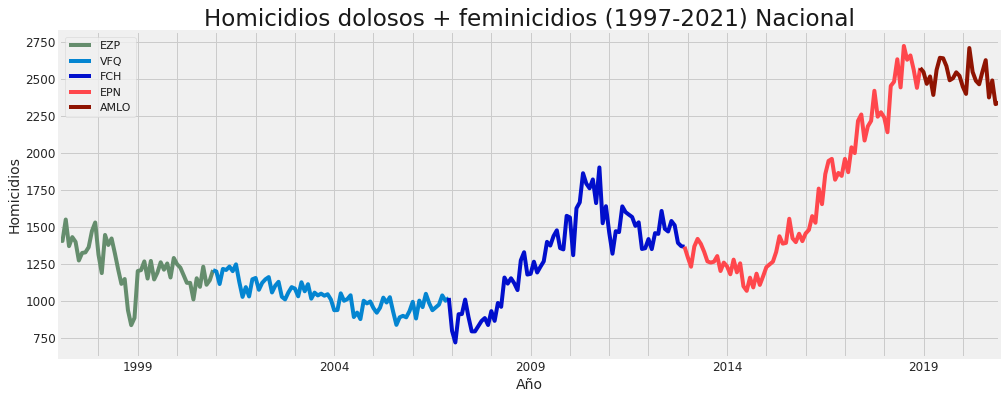

In [18]:
# Use seaborn style defaults and set the default figure size
import matplotlib
from matplotlib.dates import MonthLocator, YearLocator

sns.set(rc={'figure.figsize':(11, 4)})
plt.style.use('fivethirtyeight')


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

%matplotlib inline

fig,ax=plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

national['homicides'].loc['1997-01-01':'2000-12-01'].plot(figsize=(15, 6),color='#658d6d', label='EZP')
national['homicides'].loc['2000-12-01':'2006-12-01'].plot(figsize=(15, 6),color='#0485d1', label='VFQ')
national['homicides'].loc['2006-12-01':'2012-12-01'].plot(figsize=(15, 6),color='#010fcc', label='FCH')
national['homicides'].loc['2012-12-01':'2018-12-01'].plot(figsize=(15, 6),color='#ff474c', label='EPN')
national['homicides'].loc['2018-12-01':'2020-12-01'].plot(figsize=(15, 6),color='#8f1402', label='AMLO')

matplotlib.rcParams.update({'font.size': 16}) 
plt.title('Homicidios dolosos + feminicidios (1997-2021) Nacional')
ax.set_xlabel('Año')
ax.set_ylabel('Homicidios')
plt.legend()
#plt.grid(True)

It would look like violent homicides were decreasing until FCH "war on drugs" policy, which created a local maximum since the beggining of his term in 2006-12. A second and higher peak starts at the end of 2014. The curve starts flattening after 2019.

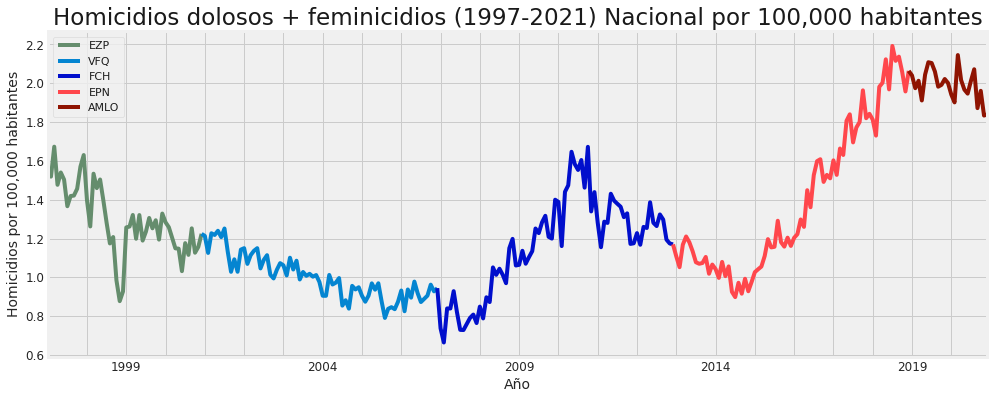

In [19]:
fig,ax=plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

national['homicides_100,000'].loc['1997-01-01':'2000-12-01'].plot(figsize=(15, 6),color='#658d6d', label='EZP')
national['homicides_100,000'].loc['2000-12-01':'2006-12-01'].plot(figsize=(15, 6),color='#0485d1', label='VFQ')
national['homicides_100,000'].loc['2006-12-01':'2012-12-01'].plot(figsize=(15, 6),color='#010fcc', label='FCH')
national['homicides_100,000'].loc['2012-12-01':'2018-12-01'].plot(figsize=(15, 6),color='#ff474c', label='EPN')
national['homicides_100,000'].loc['2018-12-01':'2020-12-01'].plot(figsize=(15, 6),color='#8f1402', label='AMLO')

matplotlib.rcParams.update({'font.size': 16}) 
plt.title('Homicidios dolosos + feminicidios (1997-2021) Nacional por 100,000 habitantes')
ax.set_xlabel('Año')
ax.set_ylabel('Homicidios por 100,000 habitantes')
plt.legend()
plt.grid(True)

When we substract the trending component that accounts for population growth, we obtain a bit of perspective of the actual fraction of population lost to crime.

$\bullet$ The first remarkable thing is that the 90's were by no means more peaceful than the war against narco. We do not have data to support this hypothesis but this first crime wave could have originated from the crisis in 1994.

$\bullet$ We have never fully recovered from such war against cartels.

$\bullet$ In the last term the local flattening appears to be a downward trend, but this could be the result of the covid-19 pandemics.

We will now use an additive model for a seasonal decomposition of the last 3 presidential terms.

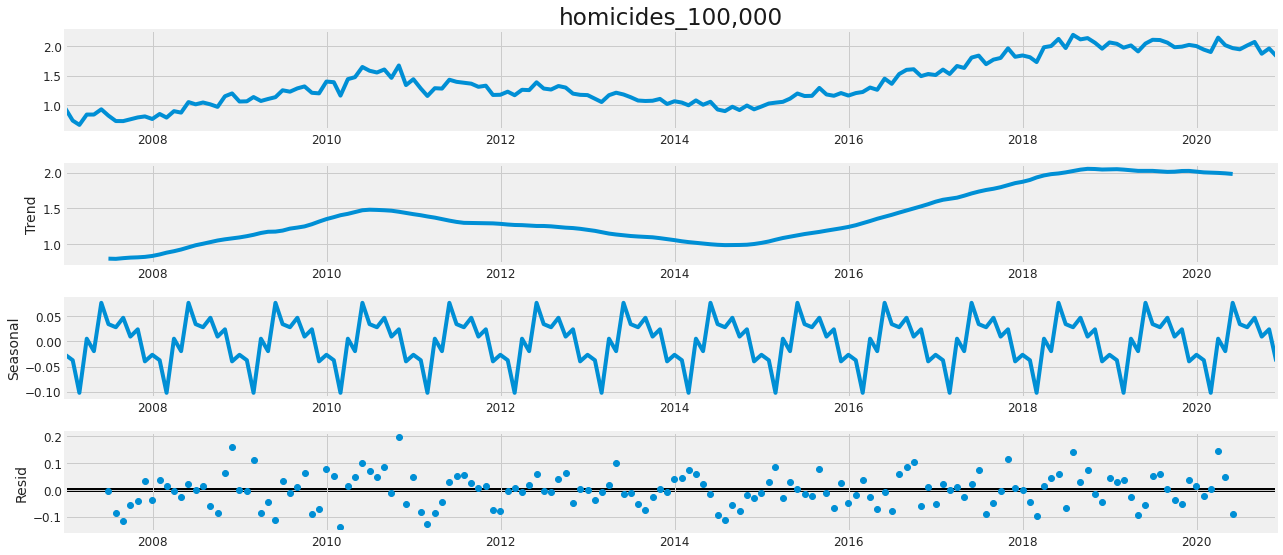

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

start, end = '2006-12-01','2020-12-01'
national['homicides_100,000']= national['homicides_100,000'].apply(pd.to_numeric)
national_monthly = (national['homicides_100,000']).resample('M').mean()
y = national_monthly.loc[start:end]
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

We can alternative use a SARIMA model, where the optimal parameters are chosen using the Akaike information criterion (AIC). This will come useful for making predictions.

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(maxiter=400, method='powell')
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 1.773222
         Iterations: 1
         Function evaluations: 13
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:597.8025954269617
Optimization terminated successfully.
         Current function value: 1.177079
         Iterations: 3
         Function evaluations: 86
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:399.4986548477201
Optimization terminated successfully.
         Current function value: -0.070838
         Iterations: 2
         Function evaluations: 50
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-21.80158588053172
Optimization terminated successfully.
         Current function value: -0.130657
         Iterations: 2
         Function evaluations: 58
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-39.90073261295001
Optimization terminated successfully.
         Current function value: -0.123211
         Iterations: 1
         Function evaluations: 50
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-37.399020851394084
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: -0.883381
         Iterations: 4
         Function evaluations: 229
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-288.8159661532611
Optimization terminated successfully.
         Current function value: -0.926368
         Iterations: 5
         Function evaluations: 253
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-303.25976209165964
Optimization terminated successfully.
         Current function value: -0.965085
         Iterations: 9
         Function evaluations: 593
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-314.26853773260757
Optimization terminated successfully.
         Current function value: -0.785921
         Iterations: 4
         Function evaluations: 213
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-256.06952651193563
Optimization terminated successfully.
         Current function value: -0.869953
         Iterations: 6
         Function evaluations: 379
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-282.30417443546105
Optimization terminat

In this case, the minimum AIC is obtained for

ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-393.97749998138596

We then train our model with such parameters

In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(method='powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: -0.977925
         Iterations: 2
         Function evaluations: 107
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0036      0.003    349.203      0.000       0.998       1.009
ma.L1         -0.3854      0.070     -5.479      0.000      -0.523      -0.248
sigma2         0.0081      0.001      9.191      0.000       0.006       0.010


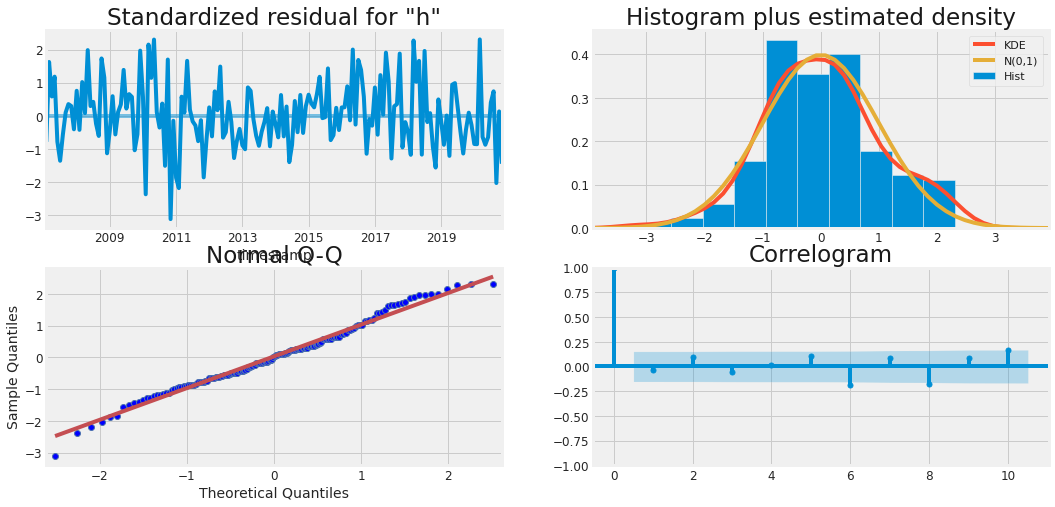

In [24]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The thing to retain from the diagnostic plots is that our SARIMA model seems to isolate a more-or-less gaussian noise and that the correlogram is compatible with zero for the monthly lags.

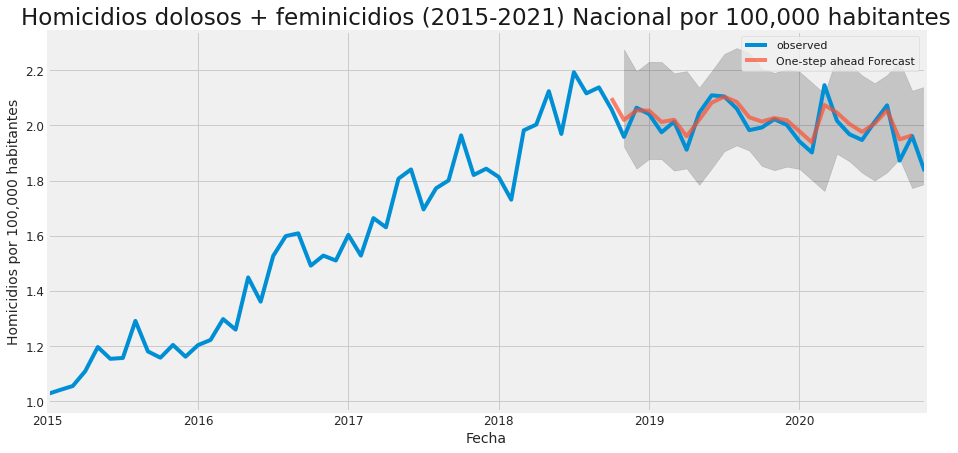

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2018-11-30'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2015':].plot(label='observed')
pred.predicted_mean.tshift(periods=-1, freq = 'M').plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.title('Homicidios dolosos + feminicidios (2015-2021) Nacional por 100,000 habitantes')
ax.set_xlabel('Fecha')
ax.set_ylabel('Homicidios por 100,000 habitantes')
plt.legend()
plt.show()

The observed and predicted data for the year 2020 are quite close. This enforces the idea that historical data (from 2015 to 2019) is the main source of the 2020 observed outcome. Except that our model could never possibly have predicted covid-19 pandemics.

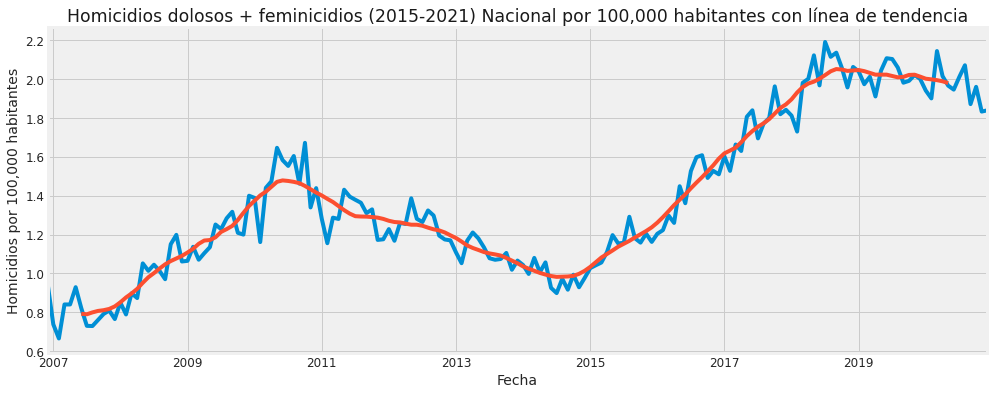

In [26]:
fig,ax=plt.subplots()
national['homicides_100,000'].loc[start:end].plot(figsize=(15, 6))
decomposition.trend.plot()
matplotlib.rcParams.update({'font.size': 12}) 
plt.title('Homicidios dolosos + feminicidios (2015-2021) Nacional por 100,000 habitantes con línea de tendencia')
ax.set_xlabel('Fecha')
ax.set_ylabel('Homicidios por 100,000 habitantes')
plt.grid(True)

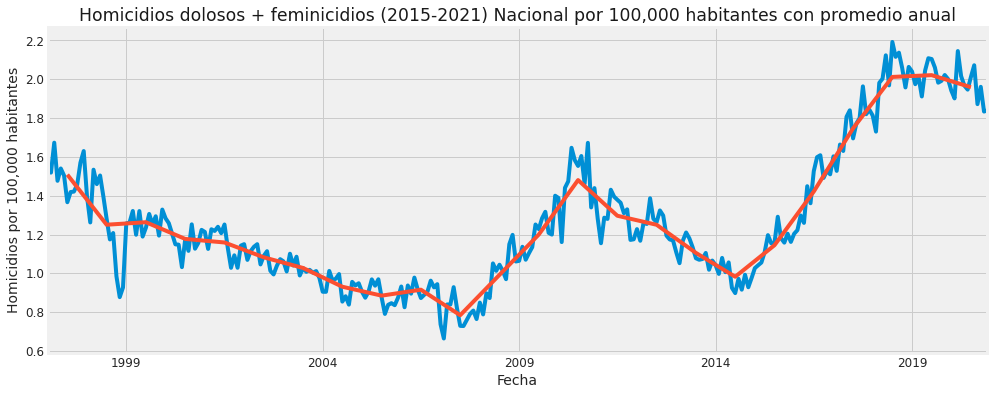

In [27]:
homicides_yearly_mean = national['homicides_100,000'].resample('Y').mean()

fig,ax=plt.subplots()
national['homicides_100,000'].plot(figsize=(15, 6))
#plt.plot(homicides_yearly_mean,'r-')
homicides_yearly_mean.tshift(periods=6, freq = 'M').plot(figsize=(15, 6))
matplotlib.rcParams.update({'font.size': 12}) 
plt.title('Homicidios dolosos + feminicidios (2015-2021) Nacional por 100,000 habitantes con promedio anual')
ax.set_xlabel('Fecha')
ax.set_ylabel('Homicidios por 100,000 habitantes')
plt.grid(True)

<AxesSubplot:title={'center':'Homicidios + feminicidios Estatal (2020)'}, xlabel='state'>

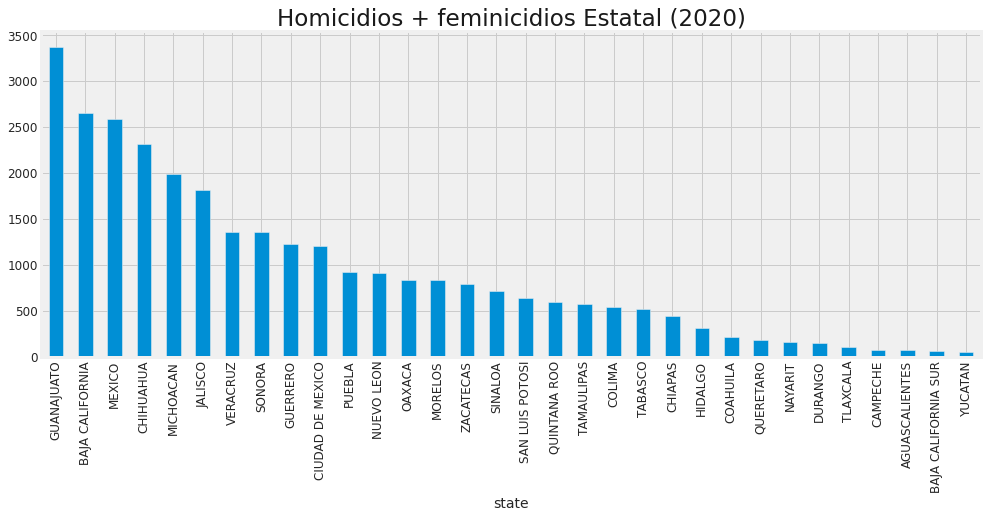

In [28]:
gk=df.loc['2020-01-01':'2020-12-01'].groupby('state')
to_hist = gk['homicides'].sum()
to_hist = pd.DataFrame(to_hist)
to_hist.sort_values('homicides',inplace=True, ascending=False)
matplotlib.rcParams.update({'font.size': 16}) 
to_hist.plot(kind='bar',title='Homicidios + feminicidios Estatal (2020)', 
             legend=False,figsize=(15, 6))

<AxesSubplot:title={'center':'Homicidios dolosos + feminicidios por cada 100,000 habitantes Estatal (2020)'}, xlabel='state'>

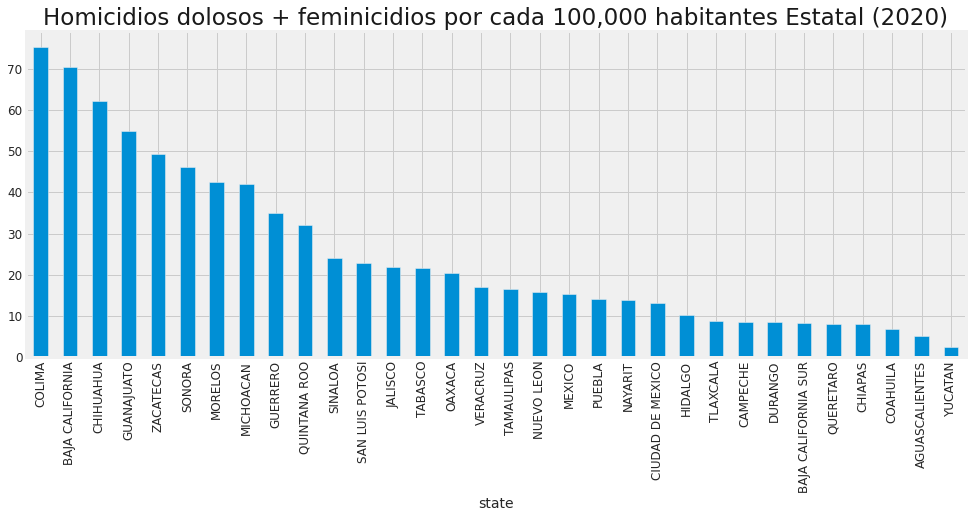

In [29]:
state_100000.sort_values('homicides_100,000',inplace=True, ascending=False)
matplotlib.rcParams.update({'font.size': 16}) 
state_100000['homicides_100,000'].plot(kind='bar',
                                       title='Homicidios dolosos + feminicidios por cada 100,000 habitantes Estatal (2020)', 
                                       legend=False,figsize=(15, 6))

# National feminicides (2015 to 2021)

I will not highlight terms with different color in this case, as only 2 presidential terms are covered by data.

And even so, we will argue that the period from 2015 to 2019 is not to be fully trusted.

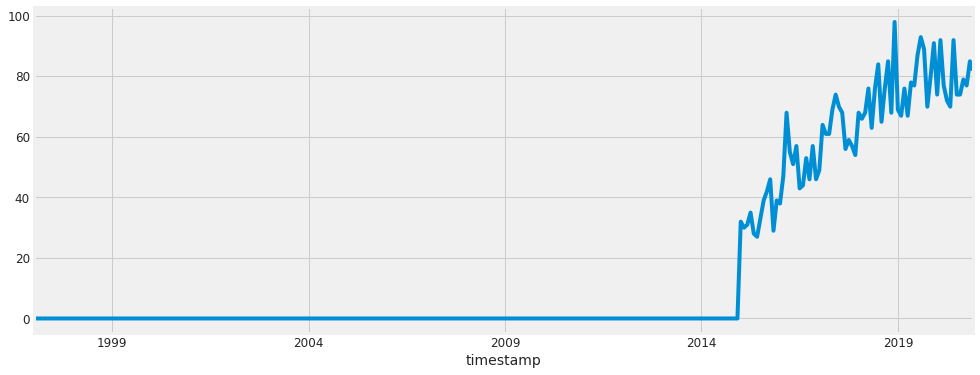

In [30]:
# Plot the national feminicide data to show how this crime was not sampled before 2015
# This plot keeps the same scale in the horizontal axis to avoid a sense of flattening due to the scale

fig,ax=plt.subplots()
national['feminicides'].plot(figsize=(15, 6))
plt.grid(True)

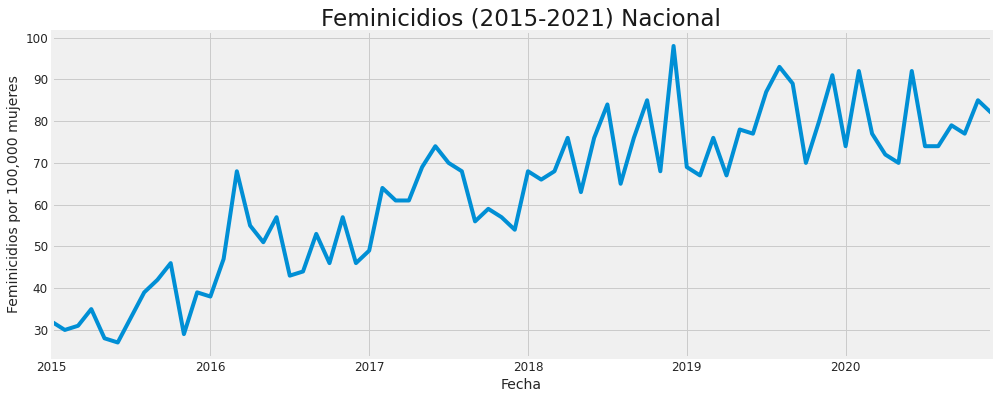

In [31]:
#Plot of the national feminicide data per 100,000 people starting from 2015

fig,ax=plt.subplots()
national['feminicides'].loc['2015-01-01':].plot(figsize=(15, 6))
ax.set_xlabel('Fecha')
ax.set_ylabel('Feminicidios por 100,000 mujeres')
plt.title('Feminicidios (2015-2021) Nacional')
plt.grid(True)

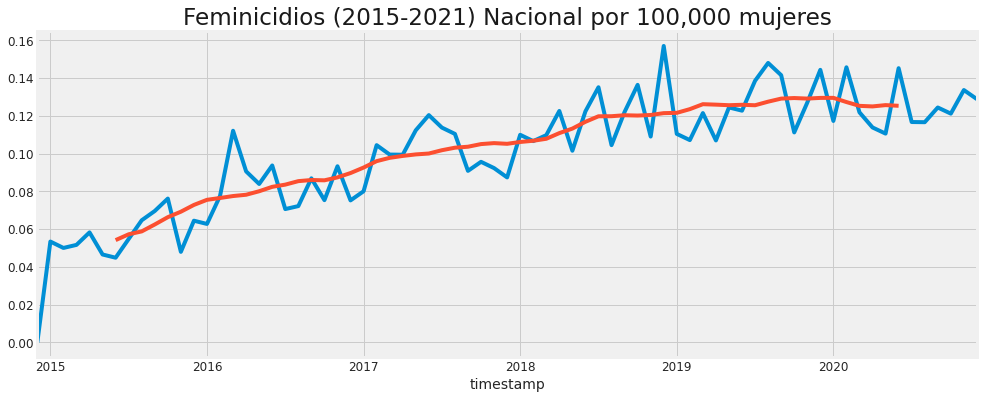

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

start, end = '2014-12-01','2021-01-01'
national['feminicides_100,000']= national['feminicides_100,000'].apply(pd.to_numeric)
national_monthly = (national['feminicides_100,000']).resample('M').mean()
y = national_monthly.loc[start:end]
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
national['feminicides_100,000'].loc[start:end].plot(figsize=(15, 6))
decomposition.trend.plot()
plt.title('Feminicidios (2015-2021) Nacional por 100,000 mujeres')
plt.show()

The trend of the previous plot is to  be taken "with a grain of salt", as it may  not reflect the real evolution of the phenomenon. The first reason is data sampling:

According to the document ["Lineamientos para el registro y clasificación de los presuntos delitos de feminicidio para fines estadísticos"](https://www.gob.mx/sesnsp/documentos/lineamientos-para-el-registro-y-clasificacion-de-los-presuntos-delitos-de-feminicidio?state=published), feminicides were gradually tipifyed as such in the different states starting from 2015 and finishing with the state of Chihuahua as late as October 2017. 

In [33]:
#Here we sort the states according to the date of their first reported feminicide

states = df['state'].unique()
sorting = pd.DataFrame(columns=['date','state'])

for s in states:
    dummy= (df['feminicides'].loc[(df['state'] == s)]).ne(0).idxmax()
    sorting = sorting.append({'date': dummy, 'state': s}, ignore_index=True)

sorting['date'] = pd.to_datetime(sorting['date'])
sorting = sorting.sort_values(by='date', ascending=True, ignore_index=True)

sorting['timestamp'] = pd.to_datetime(sorting['date'])
sorting = sorting.set_index('timestamp')
sorting = sorting.drop(columns = ['date'])

states2015 = sorting.loc['2015-01-01':'2016-01-01'].count()
states2016 = sorting.loc['2016-01-01':'2017-01-01'].count()
states2017 = sorting.loc['2017-01-01':'2018-01-01'].count()
states2018 = sorting.loc['2018-01-01':'2019-01-01'].count()
states2019 = sorting.loc['2019-01-01':'2019-12-01'].count()

print(states2015.state, 
      'states started reporting feminicides in 2015,'
      )
print(states2016.state,'in 2016,'
      ,states2017.state,'in 2017,'
      ,states2018.state,'in 2018 and'
      ,states2019.state,'in 2019.')
print(sorting.loc['2018-04-01'].state,'and',sorting.loc['2019-10-01'].state, 'were the last states to report feminicides')
print('even when the legal definition was already stablished in such states.')

23 states started reporting feminicides in 2015,
3 in 2016, 4 in 2017, 1 in 2018 and 1 in 2019.
AGUASCALIENTES and BAJA CALIFORNIA SUR were the last states to report feminicides
even when the legal definition was already stablished in such states.


Let's then disaggregate the national plot by state to understand how such contributions "turn on" along such period of time.

In [34]:
import colorsys

def get_N_HexCol(N=5):
    #This function generates N tuples equally spread in hue space, then convert 
    #them to RGB.
    #The hsv space is hue, saturation, value, so a saturation closer to 1 will
    #make stronger colours and a value closer to 1 will higher the brightness
    HSV_tuples = [(x * 1.0 / N, 0.75, 0.7) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

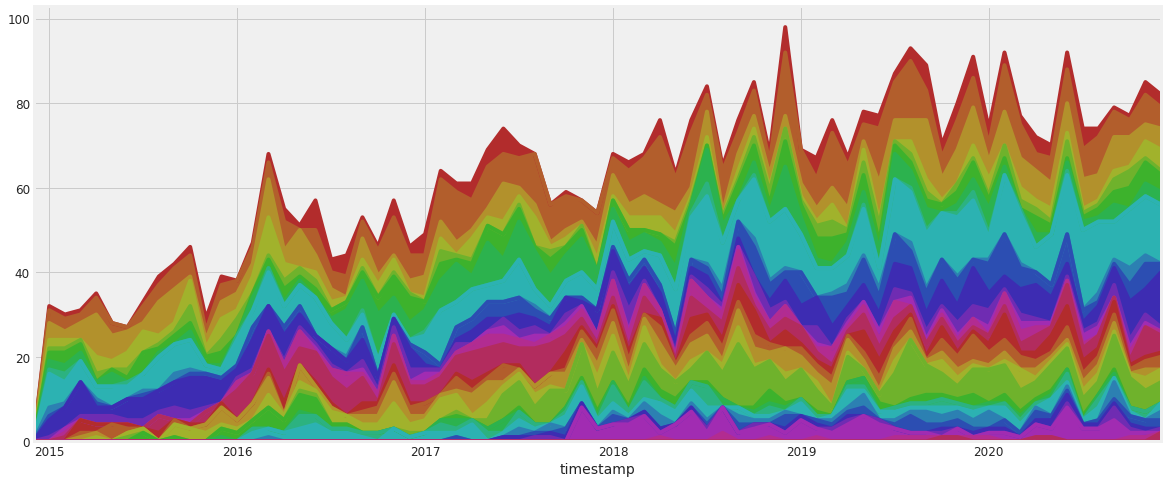

In [35]:
from cycler import cycler

#We use the previously defined function to generate the color filling of the plot
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', get_N_HexCol(16))

#We substract 
dummy = national['feminicides'].loc[start:end]
for i in range(0,32):
    dummy.plot.area(x='day')
    dummy = (dummy - df['feminicides'].loc[(df['state'] == sorting.state[i])]).loc[start:end]

The second reason is that a feminicide may not be aknowledged as such depending on the definition and local interpretetion of the Federal Criminal Code Article 325. 

To date, 7 possible reasons are denoted as feminicide. A [proposal](http://sil.gobernacion.gob.mx/Archivos/Documentos/2019/10/asun_3925259_20191003_1569348881.pdf) from the deputee María Elizabeth Díaz García from the party Morena proposes a reform to such article to aknowledge 15 possible reasons, i.e., more than the double. The same [document](http://sil.gobernacion.gob.mx/Archivos/Documentos/2019/10/asun_3925259_20191003_1569348881.pdf) mentions that approximately 1 out of every 3 female murders is reported as a feminicide. 

Neither the actual definition nor her proporsal consider hate crimes against transgender women as a feminicide.

<AxesSubplot:title={'center':'Feminicidios Estatal (2020)'}, xlabel='Estado'>

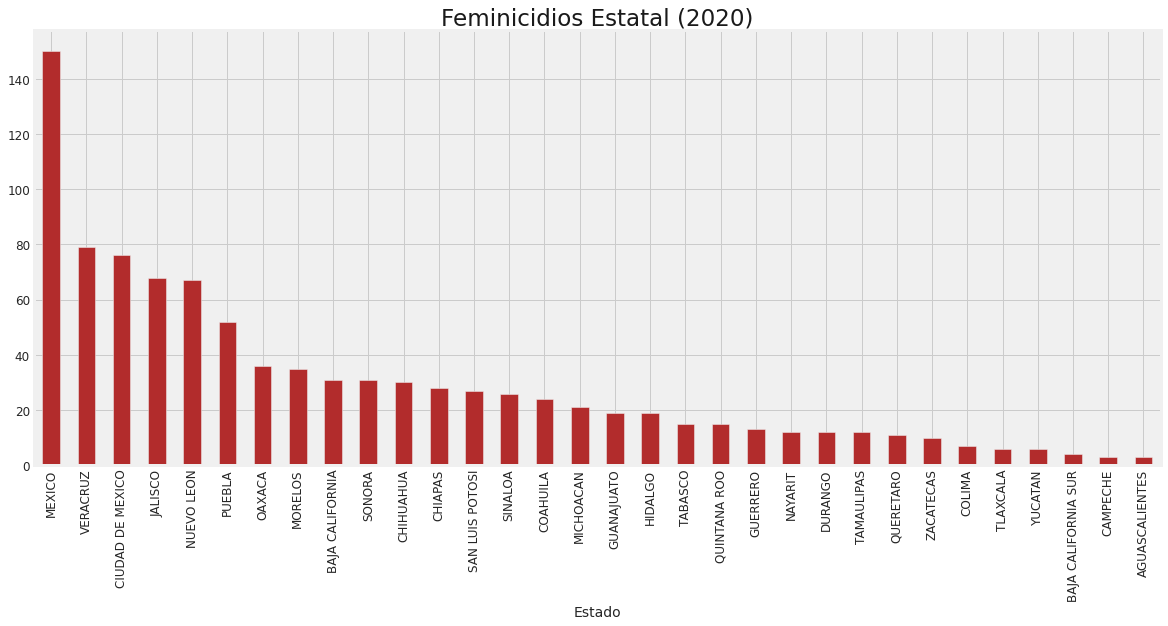

In [36]:
gk=df.loc['2020-01-01':'2020-12-01'].groupby('state')
to_hist = gk['feminicides'].sum()
to_hist = pd.DataFrame(to_hist)
to_hist.sort_values('feminicides',inplace=True, ascending=False)
matplotlib.rcParams.update({'font.size': 16}) 
to_hist.plot(kind='bar',title='Feminicidios Estatal (2020)', legend=False, xlabel='Estado')

$\bullet$ The State of Mexico is the one state with the most feminicides. 

$\bullet$ We recall that the last states to start reporting feminicides are Baja California Sur and Aguascalientes, which does not seem to contribute a lot to the trend. 

$\bullet$ Chihuahua, which started reporting at the end of 2017, has a more considerable contribution, though the exact amount in previous years is simply imposible to estimate from current data.

<AxesSubplot:title={'center':'Feminicidios por cada 100,000 mujeres Estatal (2020)'}, xlabel='Estado'>

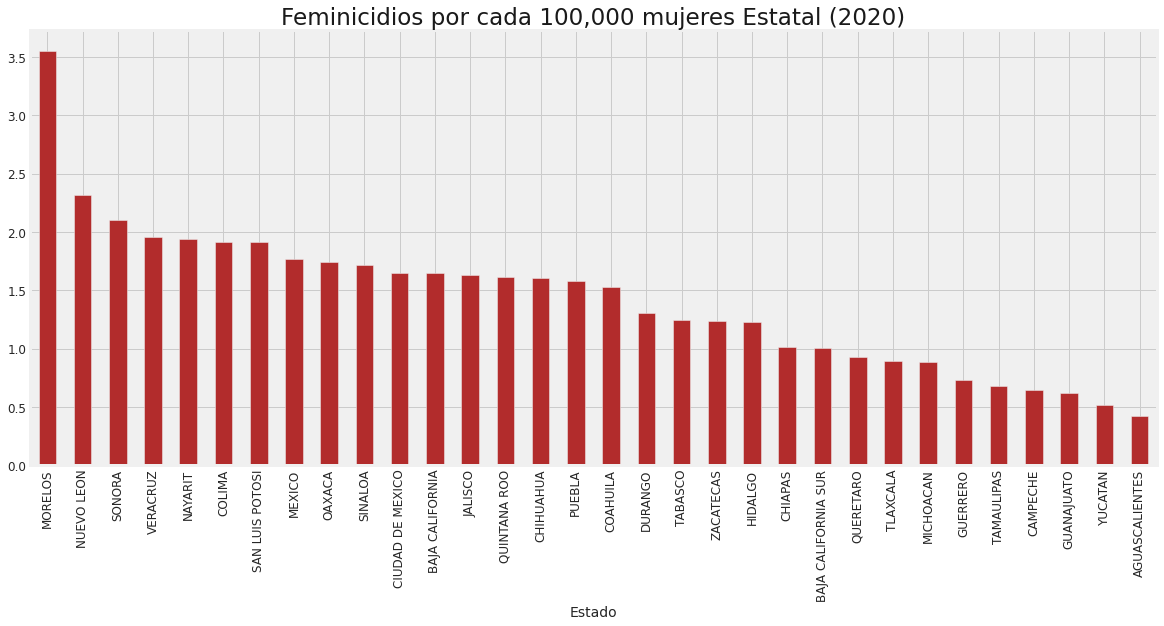

In [37]:
state_100000.sort_values('feminicides_100,000',inplace=True, ascending=False)
matplotlib.rcParams.update({'font.size': 16}) 
state_100000['feminicides_100,000'].plot(kind='bar',title='Feminicidios por cada 100,000 mujeres Estatal (2020)', legend=False, xlabel='Estado')

We have learnt by now the importance of adjusting data to (local) population. In this case a new red spot appears out of the shadows: Morelos. This might be explained by an underestimated concept: narcofeminicides.

In this case, the State of Mexico falls to the 8th place due to their enormous population, as 13.5% of the whole mexican population lives there. This does not mean that the problem in this state is less relevant, as it is still on the top quarter (Q1) of more deathly states. But there is another reason. 

# Homicides + feminicides in Mexico City (1997 to 2021)

In [38]:
#We create a national dataframe by summing over all the states

date = df['date'].unique()
cdmx = pd.DataFrame(columns=['date','homicides','homicides_100,000',
                                 'feminicides','feminicides_100,000'])
for d in date:
    p = df['homicides'].loc[(df['date'] == d)&(df['state']=='CIUDAD DE MEXICO')].sum()
    f = df['feminicides'].loc[(df['date'] == d)&(df['state']=='CIUDAD DE MEXICO')].sum()
    x = datetime.strptime(d, '%Y-%m')
    t = int(x.strftime('%Y'))+(int(x.strftime('%m'))-1)/12.
    pr = p/(10*logistic(t, *popt_cdmx))
    fr = (2*f)/(10*logistic(t, *popt_cdmx))
    cdmx = cdmx.append({'date': d, 'homicides': p, 'homicides_100,000': pr,
                                'feminicides' : f,'feminicides_100,000': fr}, 
                               ignore_index=True)
cdmx['timestamp'] = pd.to_datetime(cdmx['date'])
cdmx = cdmx.set_index('timestamp')
cdmx = cdmx.drop(columns = ['date'])
cdmx.head()

,homicides,"homicides_100,000",feminicides,"feminicides_100,000"
timestamp,,,,
1997-01-01,70,0.795116,0,0.0
1997-02-01,96,1.090212,0,0.0
1997-03-01,74,0.840194,0,0.0
1997-04-01,68,0.771908,0,0.0
1997-05-01,78,0.885239,0,0.0


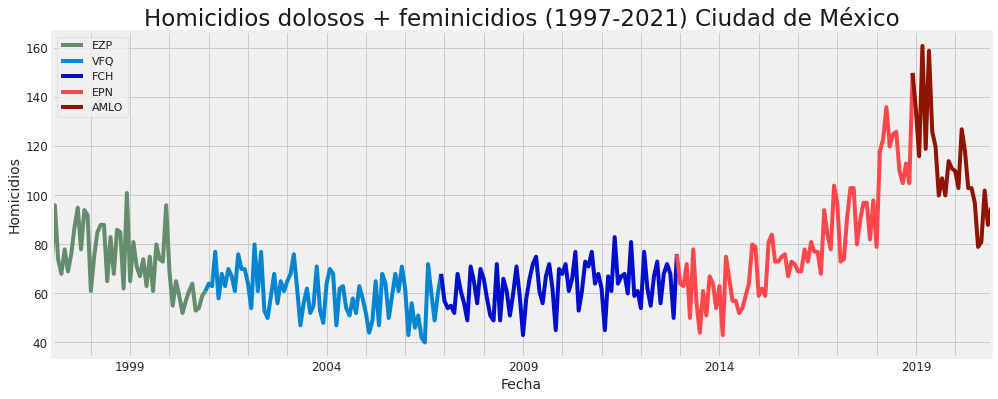

In [39]:
sns.set(rc={'figure.figsize':(11, 4)})
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

%matplotlib inline

fig,ax=plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

cdmx['homicides'].loc['1997-01-01':'2000-12-01'].plot(figsize=(15, 6),color='#658d6d', label='EZP')
cdmx['homicides'].loc['2000-12-01':'2006-12-01'].plot(figsize=(15, 6),color='#0485d1', label='VFQ')
cdmx['homicides'].loc['2006-12-01':'2012-12-01'].plot(figsize=(15, 6),color='#010fcc', label='FCH')
cdmx['homicides'].loc['2012-12-01':'2018-12-01'].plot(figsize=(15, 6),color='#ff474c', label='EPN')
cdmx['homicides'].loc['2018-12-01':'2020-12-01'].plot(figsize=(15, 6),color='#8f1402', label='AMLO')

ax.set_xlabel('Fecha')
ax.set_ylabel('Homicidios')
matplotlib.rcParams.update({'font.size': 16}) 
plt.title('Homicidios dolosos + feminicidios (1997-2021) Ciudad de México')
plt.legend()

We can notice that the peak corresponding to the war against narco policy barely affected Mexico City. Tha is not the case with the second peak starting in 2014 and that has been decreasing since the beginning of 2019, even before the Covid-19 pandemics.

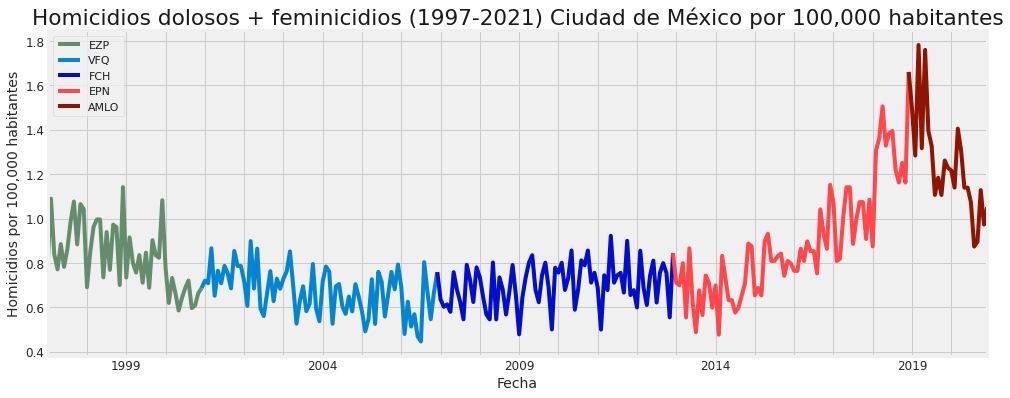

In [40]:
fig,ax=plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

cdmx['homicides_100,000'].loc['1997-01-01':'2000-12-01'].plot(figsize=(15, 6),color='#658d6d', label='EZP')
cdmx['homicides_100,000'].loc['2000-12-01':'2006-12-01'].plot(figsize=(15, 6),color='#0485d1', label='VFQ')
cdmx['homicides_100,000'].loc['2006-12-01':'2012-12-01'].plot(figsize=(15, 6),color='#010fcc', label='FCH')
cdmx['homicides_100,000'].loc['2012-12-01':'2018-12-01'].plot(figsize=(15, 6),color='#ff474c', label='EPN')
cdmx['homicides_100,000'].loc['2018-12-01':'2020-12-01'].plot(figsize=(15, 6),color='#8f1402', label='AMLO')

matplotlib.rcParams.update({'font.size': 15}) 
ax.set_xlabel('Fecha')
ax.set_ylabel('Homicidios por 100,000 habitantes')
plt.title('Homicidios dolosos + feminicidios (1997-2021) Ciudad de México por 100,000 habitantes')
plt.legend()

When we normalize the series with respect to population, we see that in fact the actual homicide rate in Mexico City is approximately the same as it was in the 90's. 

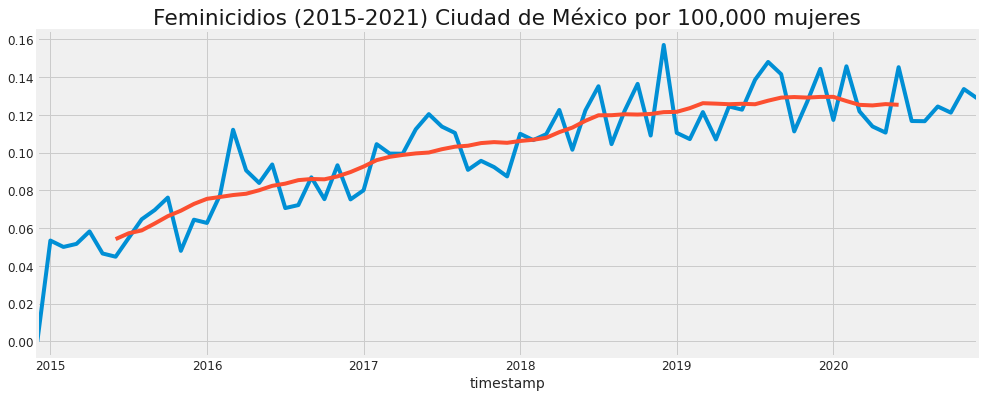

In [41]:
rcParams['figure.figsize'] = 18, 8

start, end = '2014-12-01','2021-01-01'
cdmx['feminicides_100,000']= national['feminicides_100,000'].apply(pd.to_numeric)
cdmx_monthly = (cdmx['feminicides_100,000']).resample('M').mean()
y = cdmx_monthly.loc[start:end]
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
cdmx['feminicides_100,000'].loc[start:end].plot(figsize=(15, 6))
decomposition.trend.plot()

plt.title('Feminicidios (2015-2021) Ciudad de México por 100,000 mujeres')
ax.set_xlabel('Fecha')
ax.set_ylabel('Feminicidios por 100,000 mujeres')
plt.show()

The trend of feminicides followed by Mexico City is the same as the trend for the rest of the country, which was not the case for the homicides trend. This possibly means that the underlying mechanisms are the same.

### Uncomment this cel to export the dataframe to excel

In [42]:
# writer = pd.ExcelWriter('output.xlsx')
# national['homicides'].to_excel(writer)
# writer.save()
# print('DataFrame is written successfully to Excel File.')

# Conclusions

You may be thinking: "How come the curves are flattening and even decreasing?, we all have seen the news, right?" But there are two explanations: 

- Yes, there is more crime than we have had since the start of the official compilation of data. 

- But also we are in an era with way more comunication than before, resulting in a "selection bias". 

This means our perception of crime is bigger because we had previous undersampling. For instance, we would be very wrong if we assume there were no feminicides before 2015, but as we started sampling them, our perception of the problem increased. In this same logic, if a new law (modifying the Article 325 of the Mexican Fderal Code) broadens the definition for feminicide, we will most likely see an upward trend caused by the change in sampling methods, not an actual change in the phenomenon. Unfortunately, this kind of trends are misleading to general populations and that is the reason why promoting better samplings is often discouraged by political reasons. 